In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/My Drive/IPRO/boots_1.csv')

<ipython-input-3-13b95710fc87>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/IPRO/boots_1.csv')


Step 1:

In [ ]:
# 1. Fix datatypes
df['Sample Date'] = pd.to_datetime(df['Sample Date'])
df['property_zip'] = df['property_zip'].astype(str)
df['Property Class'] = df['Property Class'].astype(str)
df['Town Code'] = df['Town Code'].astype(str)

In [ ]:
# Convert numerical columns to floats where applicable
numerical_cols = ['1st Draw', '2/3 Min', '5 Min', 'Max', 'Land Square Feet', 'Building Square Feet', 'Repair Condition']
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
# 2. Handle missing values
# Impute or drop based on the column context
df['1st Draw'].fillna(df['1st Draw'].median(), inplace=True)  # Median imputation for lead levels
df.dropna(subset=['Longitude', 'Latitude'], inplace=True)  # Drop rows with missing lat/long

<ipython-input-6-0b060bc39970>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['1st Draw'].fillna(df['1st Draw'].median(), inplace=True)  # Median imputation for lead levels


In [ ]:
# 3. Feature engineering
df['year'] = df['Sample Date'].dt.year
df['month'] = df['Sample Date'].dt.month
df['season'] = df['Sample Date'].dt.month % 12 // 3 + 1  # Simple season mapping (1 = Winter, 4 = Fall)
df['is_summer'] = df['month'].isin([6, 7, 8, 9])

In [ ]:
# Building Age Bin
df['age_bin'] = pd.cut(df['Age'], bins=[0, 25, 50, 100, np.inf], labels=["0-25", "26-50", "51-100", "100+"])

In [ ]:
# Multi-family + poor condition flag
df['multi_family_poor_condition'] = ((df['Multi Property Indicator'] == 1) & (df['Repair Condition'] == 1)).astype(int)

In [ ]:
# 4. Remove duplicates or malformed rows
df.drop_duplicates(inplace=True)

In [ ]:
# 5. Handle outliers for lead levels (Max, 1st Draw)
df['1st Draw'] = df['1st Draw'].clip(lower=0)  # Ensure no negative values
df['Max'] = df['Max'].clip(lower=0)  # Ensure no negative values

<Figure size 1000x600 with 0 Axes>

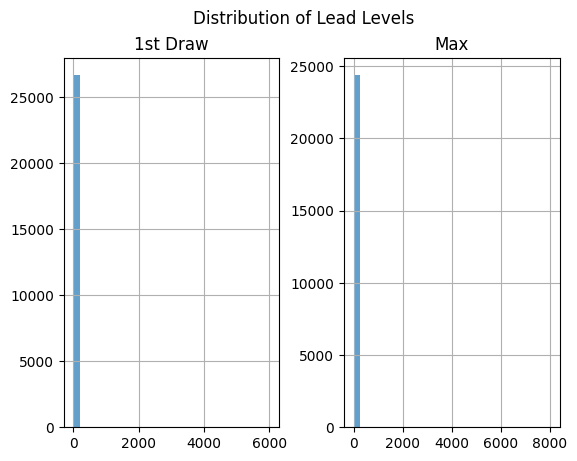

In [ ]:
# 6. EDA
# Distribution of lead levels
plt.figure(figsize=(10, 6))
df[['1st Draw', 'Max']].hist(bins=30, alpha=0.7)
plt.suptitle('Distribution of Lead Levels')
plt.show()

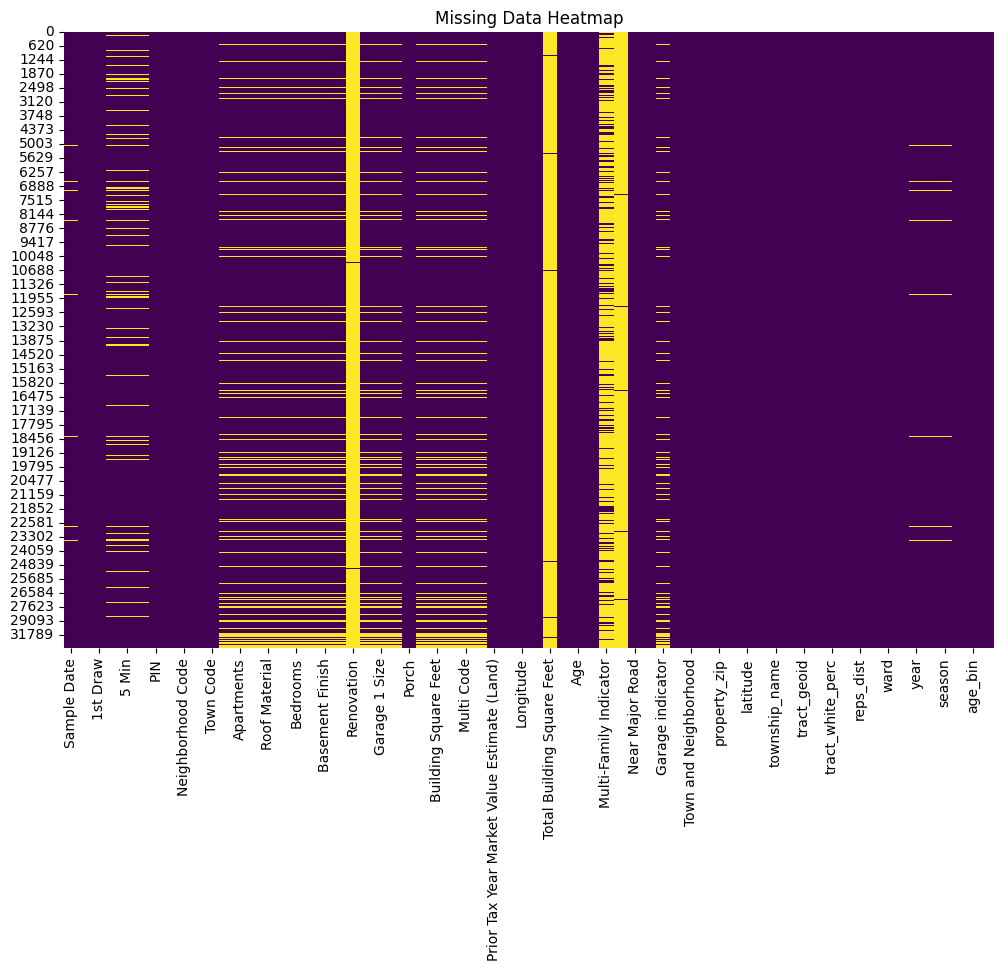

In [ ]:
# Null heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

# Yellow/light = missing
# Purple/dark = present

In [ ]:
# Display summary info and value counts
print(df.info())
print(df['Property Class'].value_counts())
print(df['season'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 26722 entries, 0 to 43778
Data columns (total 66 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Sample Date                                      26402 non-null  datetime64[ns]
 1   Address                                          26722 non-null  object        
 2   1st Draw                                         26722 non-null  float64       
 3   2/3 Min                                          24391 non-null  float64       
 4   5 Min                                            24392 non-null  float64       
 5   Max                                              24393 non-null  float64       
 6   PIN                                              26722 non-null  float64       
 7   Property Class                                   26722 non-null  object        
 8   Neighborhood Code                        

In [ ]:
# Display first few rows of processed data
print(df.head())

  Sample Date                  Address  1st Draw  2/3 Min  5 Min  Max  \
0  2018-12-11            5XX W 97TH ST       4.2      7.2    1.5  7.2   
1  2021-08-05        73XX N OTTAWA AVE       2.0      NaN    NaN  NaN   
2  2020-08-27         39XX S ELLIS AVE       3.5      6.5    3.5  6.5   
3  2019-08-07  30XX N NARRAGANSETT AVE       1.9      1.3    1.3  1.9   
4  2018-08-06        23XX W BERWYN AVE       0.5      0.5    0.5  0.5   

            PIN Property Class  Neighborhood Code  Land Square Feet  ...  \
0  2.509120e+13          203.0              282.0            4500.0  ...   
1  9.253210e+12          206.0              361.0            5320.0  ...   
2  2.002100e+13          299.0               10.0           13610.0  ...   
3  1.329110e+13          204.0              200.0            4250.0  ...   
4  1.407110e+13          205.0               12.0            4750.0  ...   

  reps_dist  senate_dist  ward  school_elem_district    year  month  season  \
0      27.0         14.0 

# Step 2:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# Group by `year_month` and plot average trends for each lead metric
df['year_month'] = df['Sample Date'].dt.to_period('M')

In [ ]:
# Calculate the average of lead metrics per year_month
lead_metrics = ['1st Draw', '2/3 Min', '5 Min', 'Max']
avg_trends = df.groupby('year_month')[lead_metrics].mean()

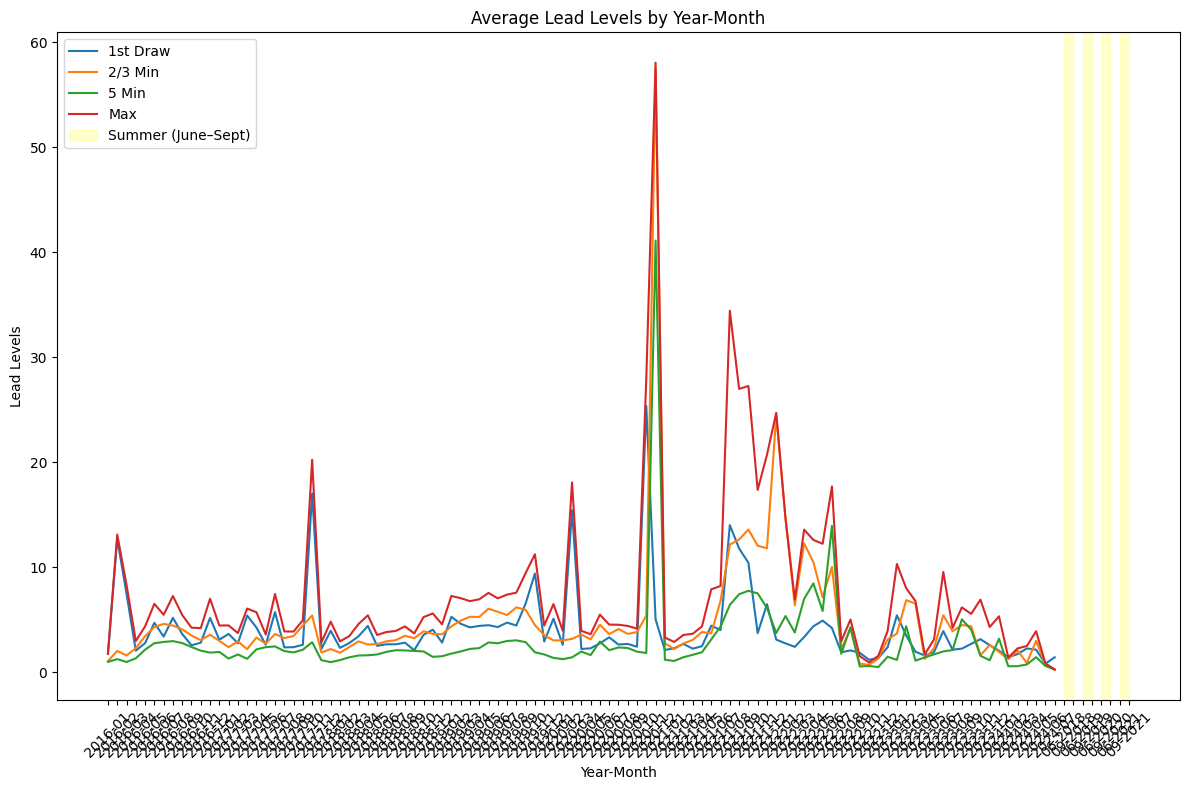

In [ ]:
# Plot the trends
plt.figure(figsize=(12, 8))
for metric in lead_metrics:
    plt.plot(avg_trends.index.astype(str), avg_trends[metric], label=metric)
plt.axvspan('06-2018', '09-2018', color='yellow', alpha=0.2, label='Summer (June–Sept)')  # Example for one year
plt.axvspan('06-2019', '09-2019', color='yellow', alpha=0.2)
plt.axvspan('06-2020', '09-2020', color='yellow', alpha=0.2)
plt.axvspan('06-2021', '09-2021', color='yellow', alpha=0.2)
plt.title('Average Lead Levels by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Lead Levels')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plots average lead metrics over time.
# Highlights summers (June–Sept) for each year using yellow shaded regions.

In [ ]:
# Seasonal Boxplots for Summer vs Non-Summer and Each Season
plt.figure(figsize=(14, 10))

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

Text(0.5, 1.0, '1st Draw Lead Levels: Summer vs Non-Summer')

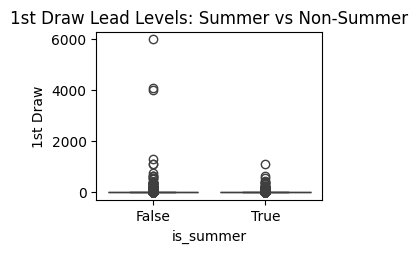

In [ ]:
# Boxplot for Summer vs Non-Summer (is_summer flag)
plt.subplot(2, 2, 1)
sns.boxplot(x='is_summer', y='1st Draw', data=df)
plt.title('1st Draw Lead Levels: Summer vs Non-Summer')

Text(0.5, 1.0, 'Max Lead Levels: Summer vs Non-Summer')

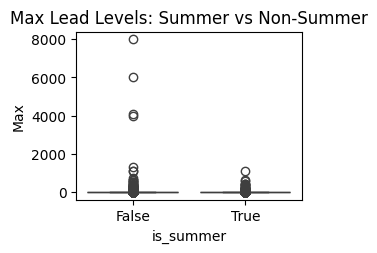

In [ ]:
plt.subplot(2, 2, 2)
sns.boxplot(x='is_summer', y='Max', data=df)
plt.title('Max Lead Levels: Summer vs Non-Summer')

Text(0.5, 1.0, '1st Draw Lead Levels by Season')

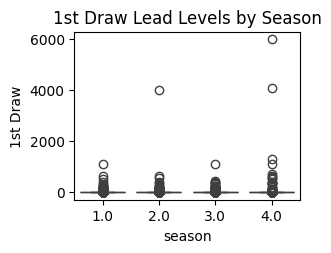

In [ ]:
# Boxplot for Each Season
plt.subplot(2, 2, 3)
sns.boxplot(x='season', y='1st Draw', data=df)
plt.title('1st Draw Lead Levels by Season')

Text(0.5, 1.0, 'Max Lead Levels by Season')

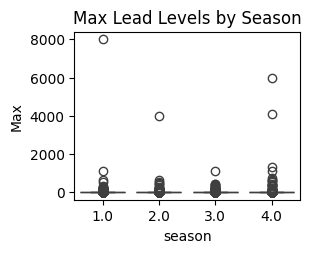

In [ ]:
plt.subplot(2, 2, 4)
sns.boxplot(x='season', y='Max', data=df)
plt.title('Max Lead Levels by Season')

In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
# Calculate Mean, Median, Std for Each Season
seasonal_stats = df.groupby('season')[lead_metrics].agg(['mean', 'median', 'std'])
print("Seasonal Statistics (Mean, Median, Std):\n", seasonal_stats)

Seasonal Statistics (Mean, Median, Std):
         1st Draw                     2/3 Min                        5 Min  \
            mean median        std      mean median         std      mean   
season                                                                      
1.0     3.959920    2.0  22.510736  5.179366    1.6  116.440788  2.772382   
2.0     4.505671    2.0  53.158530  4.410593    2.4    8.469140  2.012121   
3.0     3.971192    2.0  17.932860  4.637084    2.5    7.435280  2.620846   
4.0     5.899528    2.0  92.166459  4.861529    2.5    9.844045  2.488058   

                               Max                     
       median        std      mean median         std  
season                                                 
1.0       0.5  84.365441  7.261138    2.5  118.616227  
2.0       1.2   4.364283  6.718001    3.3   55.387611  
3.0       1.6   4.261334  6.261413    3.2   19.253987  
4.0       1.5   3.814787  8.480254    3.1   96.746736  


In [ ]:
# Statistical Tests
# 1. T-test: Summer vs Non-Summer for 1st Draw and Max
summer_data = df[df['is_summer'] == 1]
non_summer_data = df[df['is_summer'] == 0]

In [ ]:
t_test_1st_draw = stats.ttest_ind(summer_data['1st Draw'].dropna(), non_summer_data['1st Draw'].dropna())
t_test_max = stats.ttest_ind(summer_data['Max'].dropna(), non_summer_data['Max'].dropna())

In [ ]:
print(f"T-test for 1st Draw (Summer vs Non-Summer): p-value = {t_test_1st_draw.pvalue:.4f}")
print(f"T-test for Max (Summer vs Non-Summer): p-value = {t_test_max.pvalue:.4f}")

# Both p-values > 0.05 → no significant difference between summer and non-summer.

T-test for 1st Draw (Summer vs Non-Summer): p-value = 0.1836
T-test for Max (Summer vs Non-Summer): p-value = 0.2294


In [ ]:
# 2. ANOVA for Lead Levels by Season (1st Draw)
anova_1st_draw = stats.f_oneway(
    df[df['season'] == 1]['1st Draw'].dropna(),
    df[df['season'] == 2]['1st Draw'].dropna(),
    df[df['season'] == 3]['1st Draw'].dropna(),
    df[df['season'] == 4]['1st Draw'].dropna()
)

In [ ]:
print(f"ANOVA for 1st Draw (Seasons): p-value = {anova_1st_draw.pvalue:.4f}")

# Result: p = 0.1366 → Not statistically significant.
# Interpretation: No strong evidence that seasons impact 1st Draw levels.

ANOVA for 1st Draw (Seasons): p-value = 0.1366


In [ ]:
# Effect Size for t-test and ANOVA
# Cohen's d for t-test (Summer vs Non-Summer)
cohen_d_1st_draw = (summer_data['1st Draw'].mean() - non_summer_data['1st Draw'].mean()) / np.sqrt((summer_data['1st Draw'].std()**2 + non_summer_data['1st Draw'].std()**2) / 2)
cohen_d_max = (summer_data['Max'].mean() - non_summer_data['Max'].mean()) / np.sqrt((summer_data['Max'].std()**2 + non_summer_data['Max'].std()**2) / 2)

In [ ]:
print(f"Cohen's d for 1st Draw (Summer vs Non-Summer): {cohen_d_1st_draw:.4f}")
print(f"Cohen's d for Max (Summer vs Non-Summer): {cohen_d_max:.4f}")
# Very small (almost negligible) effect sizes. Reinforces earlier findings — minimal seasonal effect.

Cohen's d for 1st Draw (Summer vs Non-Summer): -0.0182
Cohen's d for Max (Summer vs Non-Summer): -0.0172


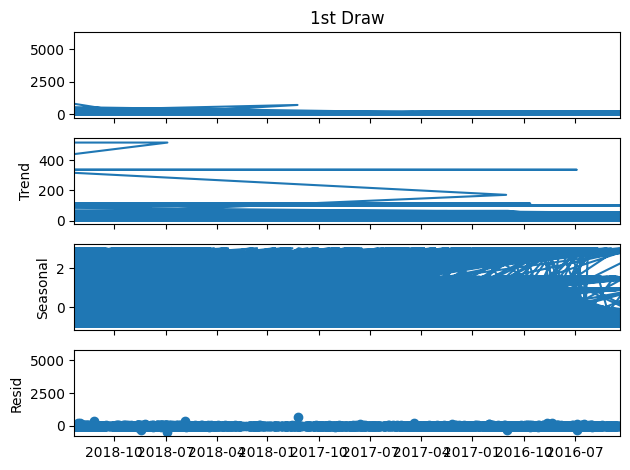

In [ ]:
# 6. Time Series Decomposition (Optional if sufficient data)
# Decompose for 1st Draw lead levels if there's enough data
df.set_index('Sample Date', inplace=True)
decomposed = seasonal_decompose(df['1st Draw'].dropna(), model='additive', period=12)  # Adjust period based on monthly data
decomposed.plot()
plt.show()

# Step 3:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, chi2_contingency
from sklearn.preprocessing import KBinsDiscretizer

In [ ]:
# Step 1: Create stagnation proxy variables
df['Age_bin'] = pd.cut(df['Age'], bins=[0, 25, 50, 75, 100, np.inf], labels=['0-25','26-50','51-75','76-100','100+'])

# Step 2: Binary flag for high lead concentration
df['high_lead_flag'] = df['Max'] > 15

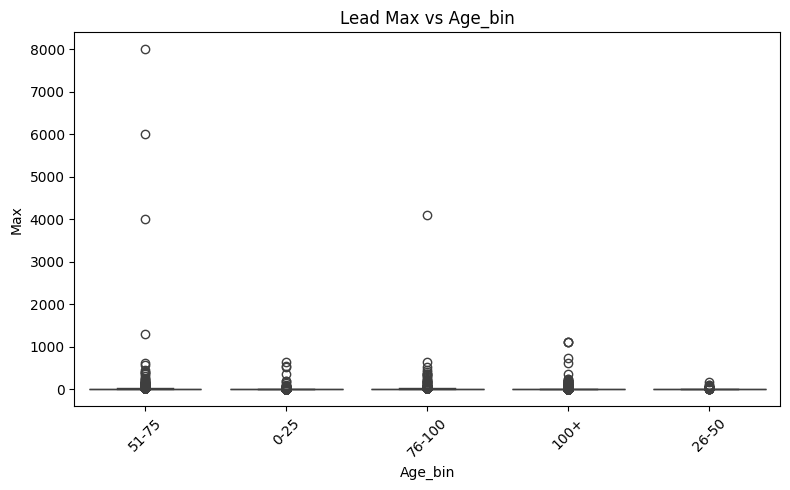

Skipped Renovation – not enough unique values to plot.


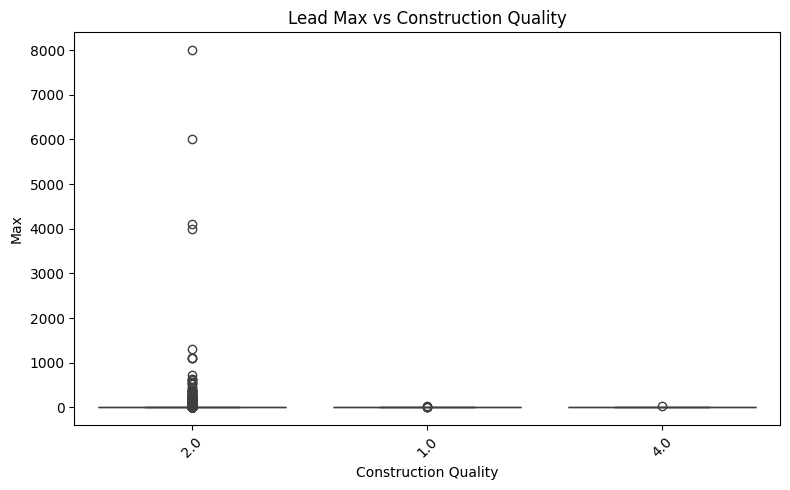

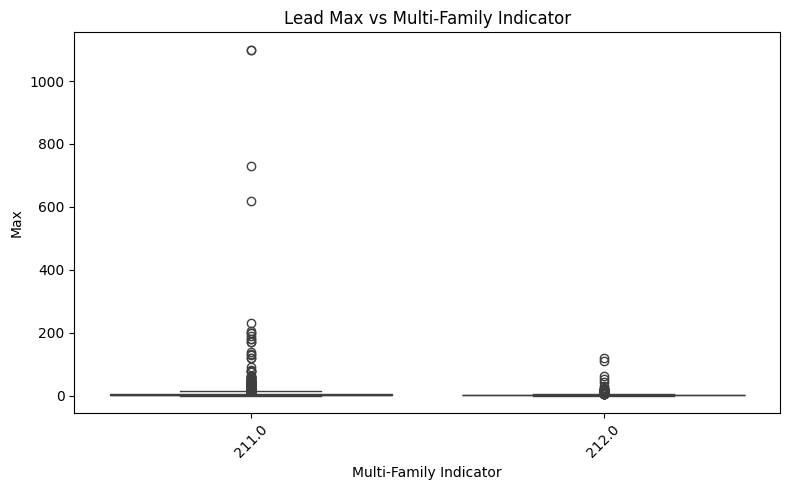

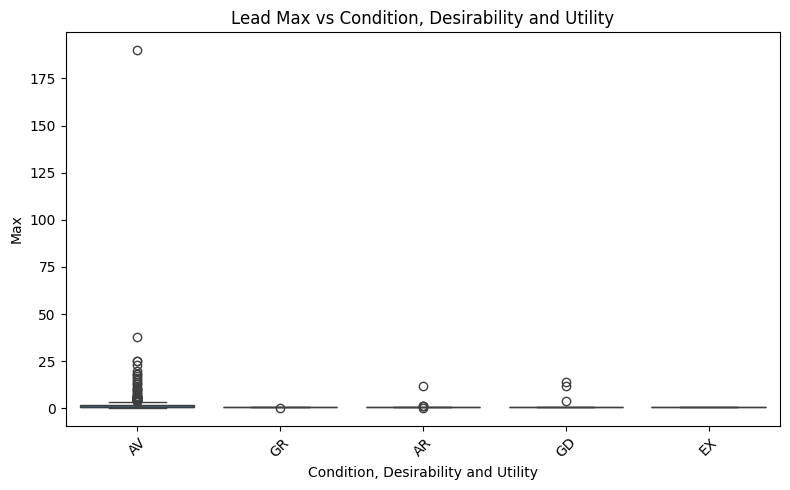

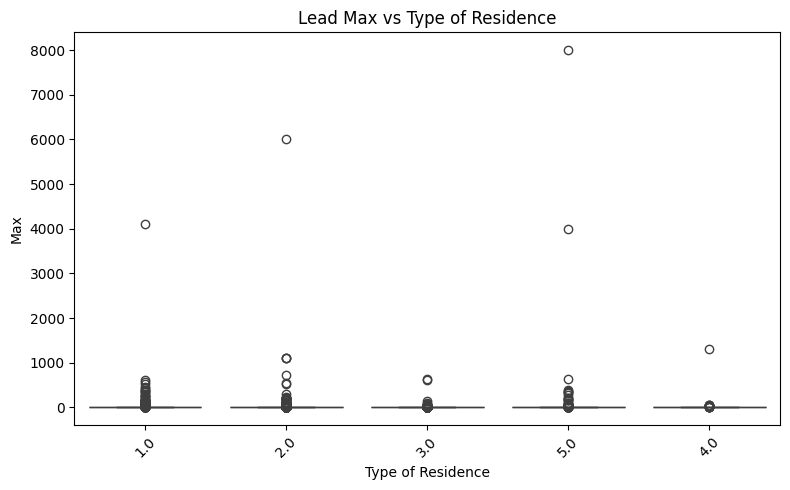

In [ ]:
# Step 3: Boxplots to inspect proxy variables vs. Max lead value
proxy_vars_categorical = ['Age_bin', 'Renovation', 'Construction Quality', 'Multi-Family Indicator',
                          'Condition, Desirability and Utility', 'Type of Residence']

for var in proxy_vars_categorical:
    if var in df.columns:
        temp = df[[var, 'Max']].dropna()
        if temp[var].nunique() > 1:
            plt.figure(figsize=(8, 5))
            sns.boxplot(x=temp[var].astype(str), y=temp['Max'])
            plt.title(f'Lead Max vs {var}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Skipped {var} – not enough unique values to plot.")


In [ ]:

# Step 4: Correlations between numeric proxies and lead metrics
proxy_vars_numeric = ['Age', 'Apartments', 'Land Square Feet', 'Building Square Feet',
                      'Total Building Square Feet', 'Rooms', 'Bedrooms']

lead_metrics = ['1st Draw', '2/3 Min', '5 Min', 'Max']

correlations = {}
for metric in lead_metrics:
    for var in proxy_vars_numeric:
        if var in df.columns and df[var].dtype in [np.float64, np.int64]:
            corr, _ = spearmanr(df[metric], df[var], nan_policy='omit')
            correlations[(var, metric)] = round(corr, 3)

correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Spearman Corr'])
correlation_df = correlation_df.reset_index()
correlation_df.columns = ['(Variable, Metric)', 'Spearman Corr']
display(correlation_df.sort_values(by='Spearman Corr', key=abs, ascending=False))


# A negative correlation (ρ < 0) means higher values of that variable are associated with lower lead.
# A positive correlation (ρ > 0) means higher values are associated with higher lead.
# Stronger correlation = value closer to -1 or +1

,"(Variable, Metric)",Spearman Corr
10,"(Building Square Feet, 2/3 Min)",-0.256
24,"(Building Square Feet, Max)",-0.254
12,"(Rooms, 2/3 Min)",-0.238
4,"(Total Building Square Feet, 1st Draw)",-0.236
26,"(Rooms, Max)",-0.235
3,"(Building Square Feet, 1st Draw)",-0.215
8,"(Apartments, 2/3 Min)",-0.215
25,"(Total Building Square Feet, Max)",-0.212
22,"(Apartments, Max)",-0.207
13,"(Bedrooms, 2/3 Min)",-0.201


<ipython-input-39-1217a553a867>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates = df.groupby(var)['high_lead_flag'].mean() * 100


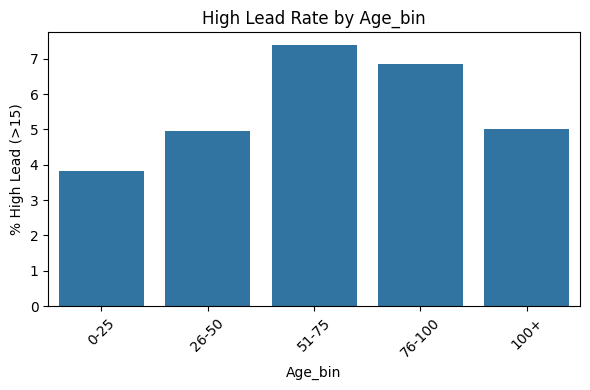

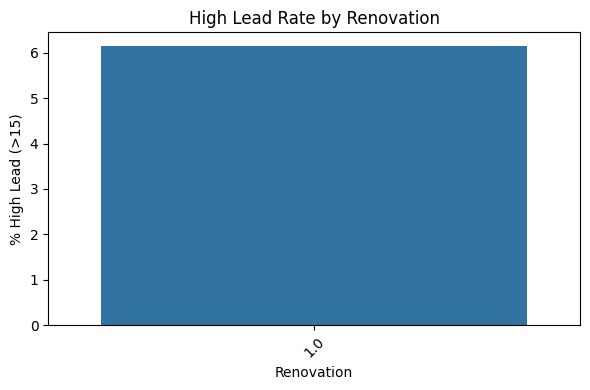

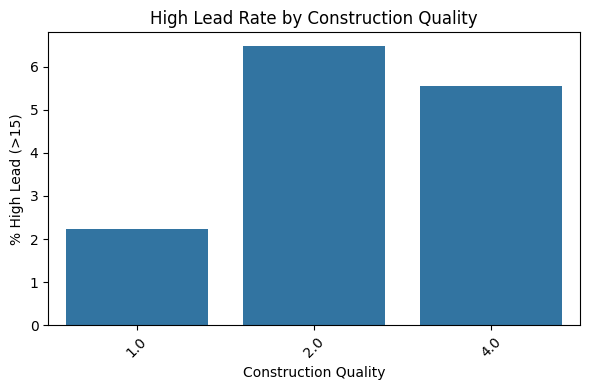

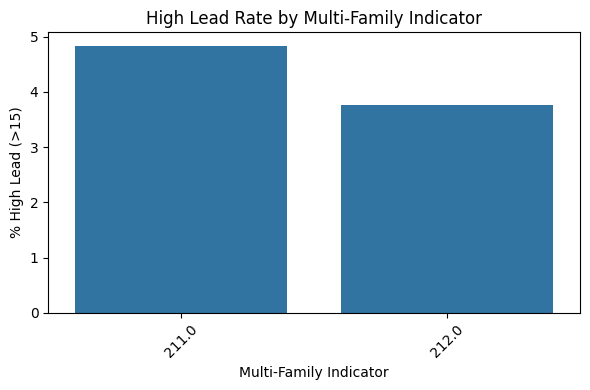

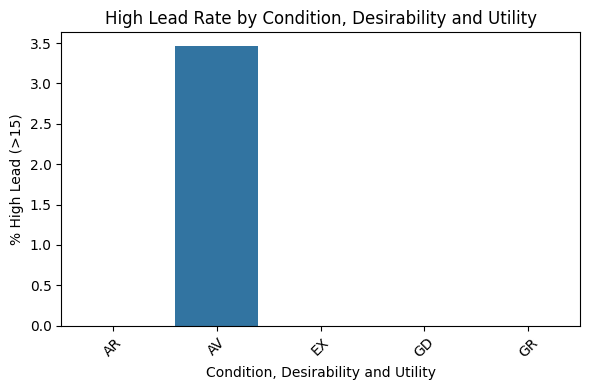

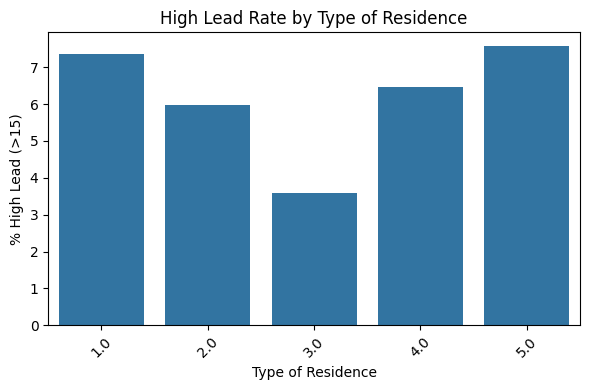

In [ ]:
# Step 5: Percentage of high lead flags across proxies
for var in proxy_vars_categorical:
    if var in df.columns:
        rates = df.groupby(var)['high_lead_flag'].mean() * 100
        plt.figure(figsize=(6,4))
        sns.barplot(x=rates.index, y=rates.values)
        plt.ylabel('% High Lead (>15)')
        plt.title(f'High Lead Rate by {var}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [ ]:
# Step 6: Chi-square tests (categorical)
for var in proxy_vars_categorical:
    if var in df.columns:
        ct = pd.crosstab(df[var], df['high_lead_flag'])
        if ct.shape[0] > 1 and ct.shape[1] > 1:
            chi2, p, _, _ = chi2_contingency(ct)
            print(f"Chi-square test for {var}: p-value = {p:.4f} {'(Significant)' if p < 0.05 else ''}")


# p < 0.05 → variable is significantly associated with lead risk
# Age_bin and Type of Residence came out significant

Chi-square test for Age_bin: p-value = 0.0000 (Significant)
Chi-square test for Construction Quality: p-value = 0.1365 
Chi-square test for Multi-Family Indicator: p-value = 0.3917 
Chi-square test for Condition, Desirability and Utility: p-value = 0.6589 
Chi-square test for Type of Residence: p-value = 0.0000 (Significant)


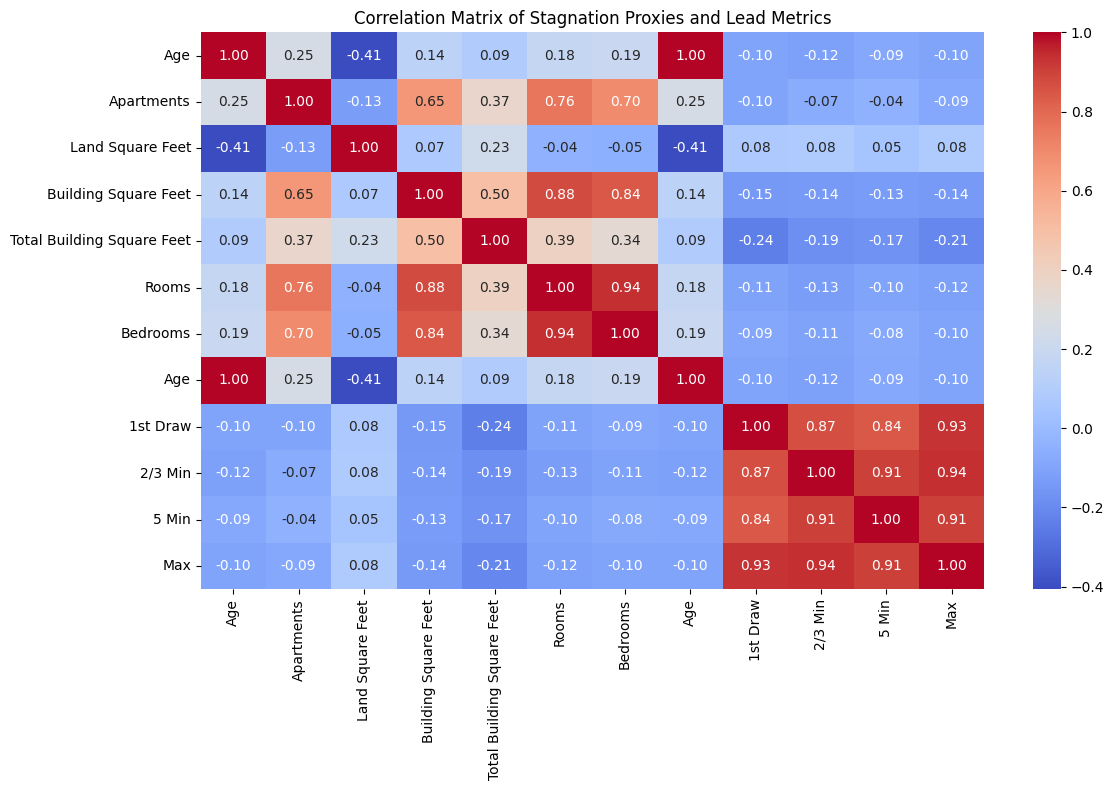

In [ ]:
# Step 7: Correlation heatmap with all stagnation proxy vars and lead metrics
selected_vars = proxy_vars_numeric + ['Age'] + lead_metrics
df_corr = df[selected_vars].dropna()

plt.figure(figsize=(12, 8))
corr_matrix = df_corr.corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Stagnation Proxies and Lead Metrics")
plt.tight_layout()
plt.show()

In [ ]:
# Step 8: Summary of strong candidate features
threshold = 0.2  # adjust as needed
strong_signals = correlation_df[correlation_df['Spearman Corr'].abs() > threshold]
print("Strong candidate stagnation proxy features based on correlation:\n")
display(strong_signals)

Strong candidate stagnation proxy features based on correlation:



,"(Variable, Metric)",Spearman Corr
3,"(Building Square Feet, 1st Draw)",-0.215
4,"(Total Building Square Feet, 1st Draw)",-0.236
8,"(Apartments, 2/3 Min)",-0.215
10,"(Building Square Feet, 2/3 Min)",-0.256
12,"(Rooms, 2/3 Min)",-0.238
13,"(Bedrooms, 2/3 Min)",-0.201
22,"(Apartments, Max)",-0.207
24,"(Building Square Feet, Max)",-0.254
25,"(Total Building Square Feet, Max)",-0.212
26,"(Rooms, Max)",-0.235


In [ ]:
print("\n📌 Significant Categorical Predictors (Chi-square p < 0.05):")
for var in proxy_vars_categorical:
    if var in df.columns:
        ct = pd.crosstab(df[var], df['high_lead_flag'])
        if ct.shape[0] > 1 and ct.shape[1] > 1:
            chi2, p, _, _ = chi2_contingency(ct)
            if p < 0.05:
                print(f" - {var}: p = {p:.4f} ✅")

print("\n📌 Strongest Correlations with Lead Metrics (|ρ| > 0.2):")
for i, row in strong_signals.iterrows():
    var_metric = row['(Variable, Metric)']
    rho = row['Spearman Corr']
    print(f" - {var_metric}: ρ = {rho:.2f}")


📌 Significant Categorical Predictors (Chi-square p < 0.05):
 - Age_bin: p = 0.0000 ✅
 - Type of Residence: p = 0.0000 ✅

📌 Strongest Correlations with Lead Metrics (|ρ| > 0.2):
 - ('Building Square Feet', '1st Draw'): ρ = -0.21
 - ('Total Building Square Feet', '1st Draw'): ρ = -0.24
 - ('Apartments', '2/3 Min'): ρ = -0.21
 - ('Building Square Feet', '2/3 Min'): ρ = -0.26
 - ('Rooms', '2/3 Min'): ρ = -0.24
 - ('Bedrooms', '2/3 Min'): ρ = -0.20
 - ('Apartments', 'Max'): ρ = -0.21
 - ('Building Square Feet', 'Max'): ρ = -0.25
 - ('Total Building Square Feet', 'Max'): ρ = -0.21
 - ('Rooms', 'Max'): ρ = -0.23


In [ ]:
# Step 8: Summary of strong candidate features
threshold = 0.2  # Can tune based on desired signal strength

# Filter correlations above threshold
strong_signals_df = correlation_df[correlation_df['Spearman Corr'].abs() > threshold].sort_values(by='Spearman Corr', key=abs, ascending=False)

print("Strong candidate stagnation proxies (|Spearman Corr| > 0.2):")
display(strong_signals_df)


Strong candidate stagnation proxies (|Spearman Corr| > 0.2):


,"(Variable, Metric)",Spearman Corr
10,"(Building Square Feet, 2/3 Min)",-0.256
24,"(Building Square Feet, Max)",-0.254
12,"(Rooms, 2/3 Min)",-0.238
4,"(Total Building Square Feet, 1st Draw)",-0.236
26,"(Rooms, Max)",-0.235
3,"(Building Square Feet, 1st Draw)",-0.215
8,"(Apartments, 2/3 Min)",-0.215
25,"(Total Building Square Feet, Max)",-0.212
22,"(Apartments, Max)",-0.207
13,"(Bedrooms, 2/3 Min)",-0.201


In [ ]:
# Optional: Save to CSV
strong_signals_df.to_csv('/content/drive/My Drive/IPRO/strong_stagnation_proxies.csv', index=False)


In [ ]:
import folium

# Red Circles represent areas with higher levels of contamination (where high_lead_flag = 1).
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
lead_map = folium.Map(location=map_center, zoom_start=11)

for _, row in df[df['high_lead_flag'] == 1].iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.5,
    ).add_to(lead_map)

lead_map

# Step 4:

In [ ]:
# import folium
# from folium.plugins import HeatMap

# # Clean data: Drop rows where Latitude, Longitude, or Max is NaN
# df_clean = df.dropna(subset=['Latitude', 'Longitude', 'Max'])

# # Base map centered on Chicago
# chi_map = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# # Add lead samples with color by Max level
# for idx, row in df_clean.iterrows():
#     color = 'red' if row['Max'] > 15 else 'blue'
#     folium.CircleMarker(
#         location=[row['Latitude'], row['Longitude']],
#         radius=3,
#         color=color,
#         fill=True,
#         popup=f"Max: {row['Max']}, Tract: {row['tract_geoid']}"
#     ).add_to(chi_map)

# # Heatmap of lead concentration (now NaN-free)
# HeatMap(data=df_clean[['Latitude', 'Longitude', 'Max']].values, radius=15).add_to(chi_map)

# chi_map.save('/content/drive/My Drive/IPRO/lead_map.html')

In [ ]:
import pandas as pd
import folium
import geopandas as gpd
from sklearn.cluster import DBSCAN
from folium.plugins import HeatMap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# # Filter out rows with NaN values in latitude or longitude
# df_clean = df.dropna(subset=['latitude', 'longitude'])

# # Initialize the map at the centroid of the data
# latitude = df_clean['latitude'].mean()
# longitude = df_clean['longitude'].mean()
# m = folium.Map(location=[latitude, longitude], zoom_start=12)

# # Plot the cleaned data points
# for idx, row in df_clean.iterrows():
#     folium.CircleMarker(
#         location=[row['latitude'], row['longitude']],
#         radius=5,
#         color='blue',
#         fill=True,
#         fill_color='blue',
#         fill_opacity=0.6
#     ).add_to(m)

# m


In [ ]:

# Assuming df is already loaded
# Convert the longitude and latitude to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))

In [ ]:
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)
df = df.dropna(subset=['latitude', 'longitude'])
# Add points to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue' if row['Max'] <= 15 else 'red',  # Red for Max > 15
        fill=True,
        fill_color='blue' if row['Max'] <= 15 else 'red',
        fill_opacity=0.7
    ).add_to(m)

# Save the map to an HTML file
m.save('/content/drive/My Drive/IPRO/lead_contamination_map.html')

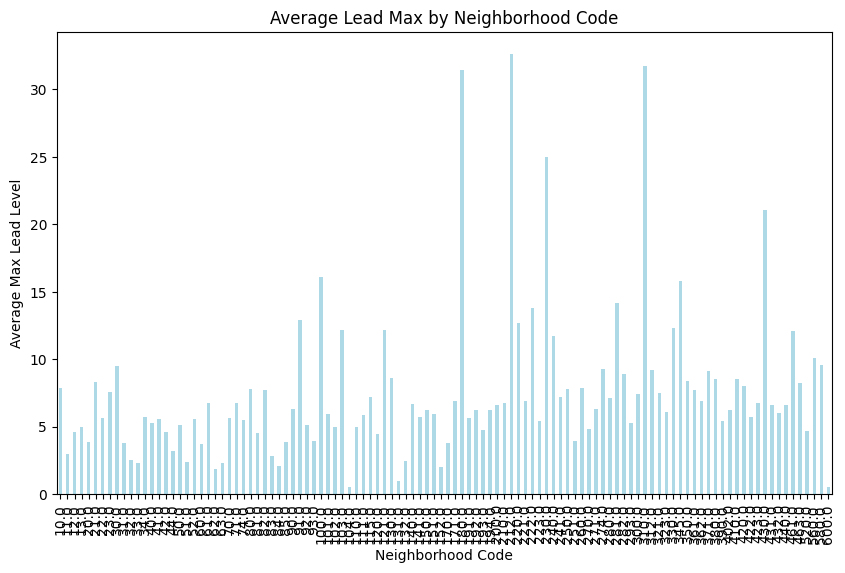

In [ ]:
# Aggregation by Neighborhood Code and Census Tract
agg_neighborhood = df.groupby('Neighborhood Code')['Max'].mean()
agg_tract = df.groupby('tract_geoid')['Max'].mean()

# Aggregating by Ward
agg_ward = df.groupby('ward')['Max'].mean()

# Visualize average lead levels by Neighborhood Code
plt.figure(figsize=(10, 6))
agg_neighborhood.plot(kind='bar', color='lightblue')
plt.title('Average Lead Max by Neighborhood Code')
plt.xlabel('Neighborhood Code')
plt.ylabel('Average Max Lead Level')
plt.xticks(rotation=90)
plt.show()


# This visualizes the average Max lead levels across different neighborhood codes.

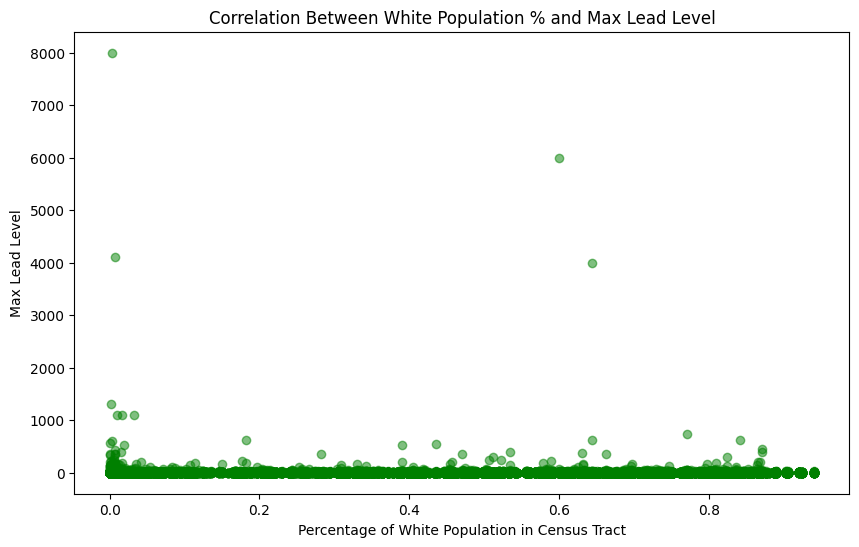

In [ ]:
# Correlation between white population percentage and lead levels
plt.figure(figsize=(10, 6))
plt.scatter(df['tract_white_perc'], df['Max'], alpha=0.5, color='green')
plt.title('Correlation Between White Population % and Max Lead Level')
plt.xlabel('Percentage of White Population in Census Tract')
plt.ylabel('Max Lead Level')
plt.show()

In [ ]:
# Perform DBSCAN clustering
from sklearn.preprocessing import StandardScaler
coordinates = df[['longitude', 'latitude', 'Max']].dropna()
scaler = StandardScaler()
scaled_coords = scaler.fit_transform(coordinates[['longitude', 'latitude', 'Max']])

<ipython-input-55-a25bf4583033>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cluster'] = db.labels_


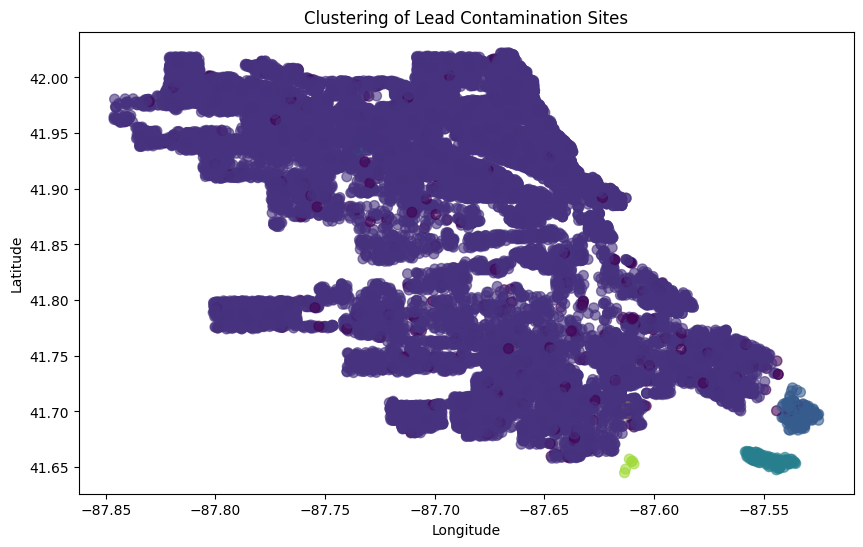

In [ ]:
# Drop rows where longitude, latitude, or Max lead levels are missing
df_cleaned = df.dropna(subset=['longitude', 'latitude', 'Max'])

# Extract coordinates and lead levels for DBSCAN
coordinates = df_cleaned[['longitude', 'latitude', 'Max']]

# Standardize the coordinates and lead levels
scaler = StandardScaler()
scaled_coords = scaler.fit_transform(coordinates)

# Apply DBSCAN
db = DBSCAN(eps=0.1, min_samples=5).fit(scaled_coords)

# Assign cluster labels to the cleaned DataFrame
df_cleaned['cluster'] = db.labels_

# Plot clusters on a map
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['longitude'], df_cleaned['latitude'], c=df_cleaned['cluster'], cmap='viridis', alpha=0.6, s=50)
plt.title('Clustering of Lead Contamination Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:


# Get cluster centroids
centroids = df_cleaned.groupby('cluster').agg({'longitude': 'mean', 'latitude': 'mean', 'Max': 'mean'}).reset_index()

# Exclude noise points (label -1 indicates noise in DBSCAN)
centroids = centroids[centroids['cluster'] != -1]

# Save the centroids to a CSV file
centroids.to_csv('/content/drive/My Drive/IPRO/lead_clusters_centroids.csv', index=False)

# Step 5:

In [ ]:
# Step 1: Identify the top 5 neighborhoods or census tracts with the highest average Max lead levels
top_areas = df.groupby(['Neighborhood Code', 'tract_geoid']).agg({'Max': 'mean'}).reset_index()

# Sort by average Max contamination and get the top 5
top_areas = top_areas.sort_values(by='Max', ascending=False).head(5)
print(top_areas)


     Neighborhood Code   tract_geoid         Max
496               91.0  1.703184e+10  139.750000
783              180.0  1.703151e+10  127.600000
133               30.0  1.703113e+10   99.234462
379               70.0  1.703183e+10   91.100000
838              230.0  1.703150e+10   86.135714


<ipython-input-58-7013f1ccb9bb>:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/IPRO/boots_1.csv', dtype={'Sample Date': str})


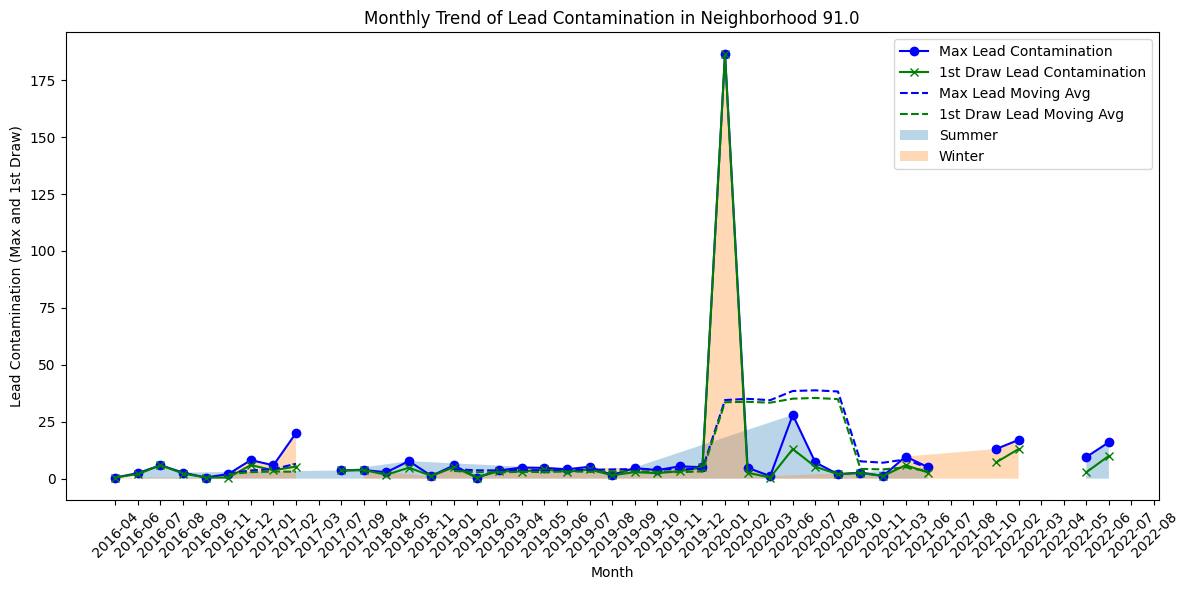

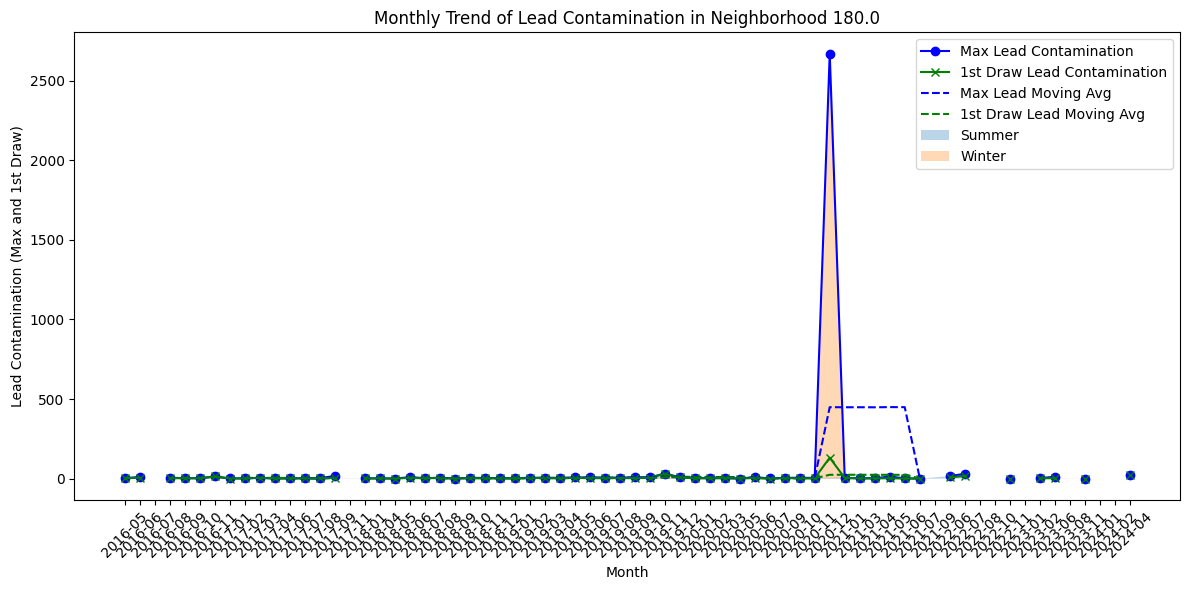

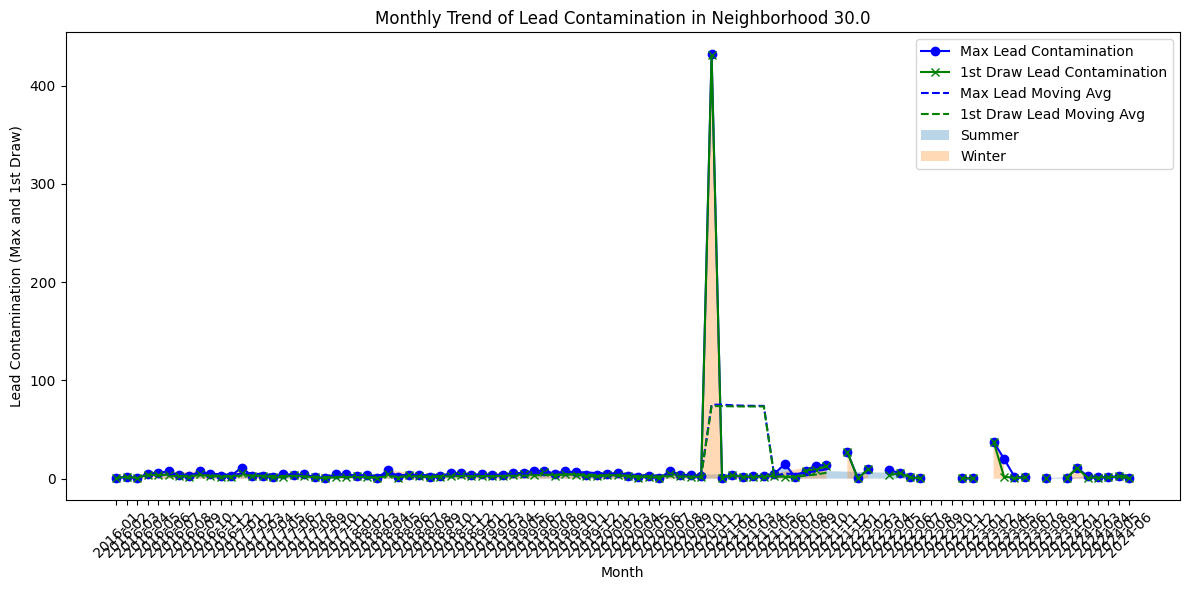

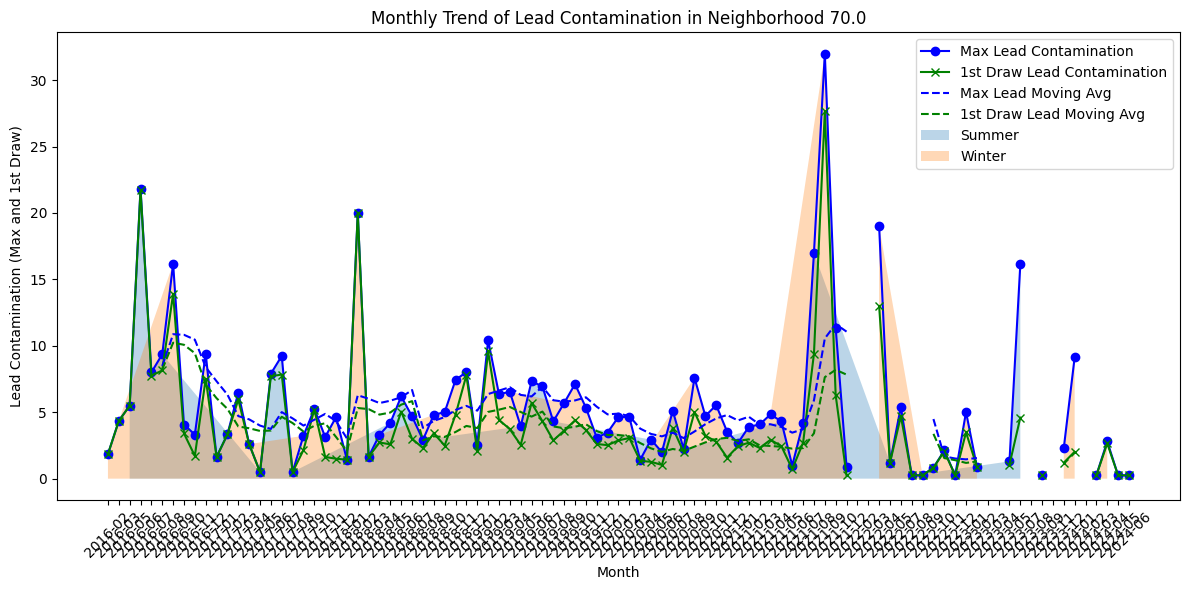

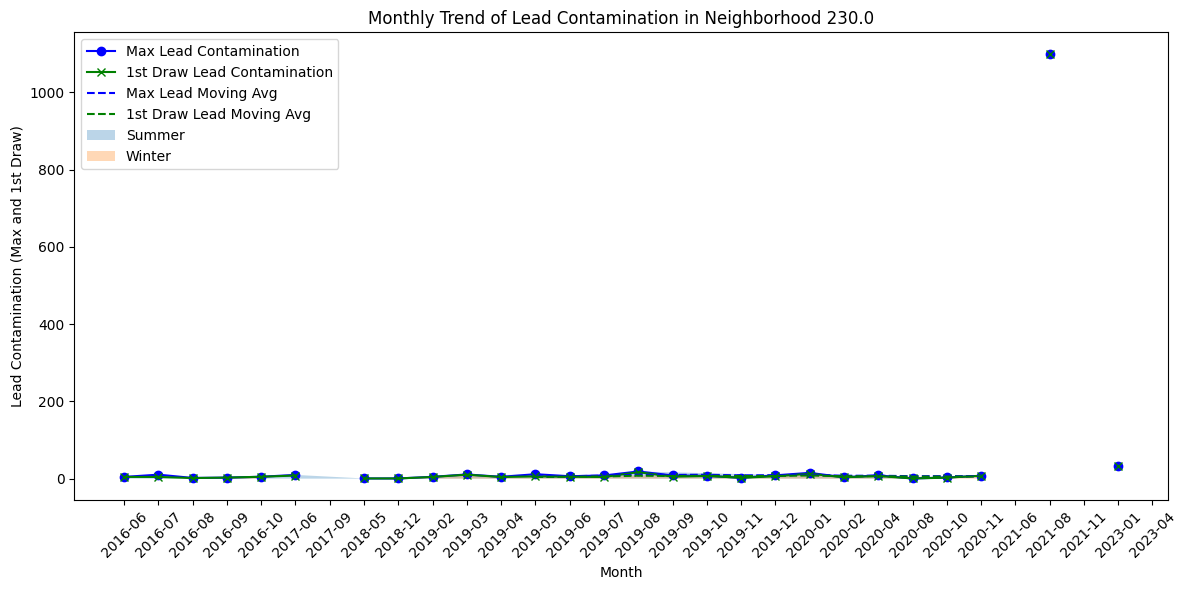

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Read the CSV file with dtype specified to avoid mixed types issue
df = pd.read_csv('/content/drive/My Drive/IPRO/boots_1.csv', dtype={'Sample Date': str})

# Convert 'Sample Date' to datetime format
df['Sample Date'] = pd.to_datetime(df['Sample Date'], errors='coerce')

# Loop through top areas (assuming 'top_areas' is defined elsewhere)
for area in top_areas['Neighborhood Code']:
    # Filter data for the specific area
    area_data = df[df['Neighborhood Code'] == area].copy()

    # Add year-month column to group by
    area_data['YearMonth'] = area_data['Sample Date'].dt.to_period('M')

    # Group by month and calculate mean Max and 1st Draw
    monthly_data = area_data.groupby('YearMonth').agg({'Max': 'mean', '1st Draw': 'mean'}).reset_index()

    # Plot monthly trends of Max and 1st Draw lead contamination
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_data['YearMonth'].astype(str), monthly_data['Max'], label='Max Lead Contamination', color='blue', marker='o')
    plt.plot(monthly_data['YearMonth'].astype(str), monthly_data['1st Draw'], label='1st Draw Lead Contamination', color='green', marker='x')

    # Add moving average or regression line for long-term trend
    rolling_max = monthly_data['Max'].rolling(window=6).mean()
    rolling_1st = monthly_data['1st Draw'].rolling(window=6).mean()
    plt.plot(monthly_data['YearMonth'].astype(str), rolling_max, label='Max Lead Moving Avg', linestyle='--', color='blue')
    plt.plot(monthly_data['YearMonth'].astype(str), rolling_1st, label='1st Draw Lead Moving Avg', linestyle='--', color='green')

    # Seasonal indicators (Summer vs Winter)
    summer_months = [5, 6, 7, 8]  # May to August (Summer)
    area_data['Season'] = np.where(area_data['Sample Date'].dt.month.isin(summer_months), 'Summer', 'Winter')

    # Create a mapping of season for the monthly data
    monthly_data['Season'] = np.where(monthly_data['YearMonth'].dt.month.isin(summer_months), 'Summer', 'Winter')

    # Plot seasonal shading
    for season in ['Summer', 'Winter']:
        season_data = monthly_data[monthly_data['Season'] == season]
        plt.fill_between(season_data['YearMonth'].astype(str), 0, season_data['Max'], alpha=0.3, label=season)

    # Labels and title
    plt.title(f'Monthly Trend of Lead Contamination in Neighborhood {area}')
    plt.xlabel('Month')
    plt.ylabel('Lead Contamination (Max and 1st Draw)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# Step 3: Filter for tracts with highest percentage of non-white populations
top_non_white_tracts = df.groupby('tract_geoid').agg({'tract_white_perc': 'mean'}).reset_index()

# Sort tracts by lowest percentage of white population
top_non_white_tracts = top_non_white_tracts.sort_values(by='tract_white_perc', ascending=True).head(5)
print(top_non_white_tracts)


      tract_geoid  tract_white_perc
501  1.703153e+10               0.0
725  1.703184e+10               0.0
711  1.703183e+10               0.0
717  1.703184e+10               0.0
475  1.703149e+10               0.0


# Step 6:

Assumptions Made:

The data was aggregated at the monthly level (could be weekly depending on trends).

Seasonality was modeled with a period of 12 for monthly data (i.e., annual seasonality).

In [19]:
# Read the CSV file with dtype specified to avoid mixed types issue
df = pd.read_csv('/content/drive/My Drive/IPRO/boots_1.csv', dtype={'Sample Date': str})

<ipython-input-19-e9cf5b5c67a1>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/IPRO/boots_1.csv', dtype={'Sample Date': str})


In [20]:
# Convert 'Sample Date' to datetime format
df['Sample Date'] = pd.to_datetime(df['Sample Date'], errors='coerce')

# Handle missing values in columns related to lead levels (1st Draw, 2/3 Min, 5 Min, Max)
# Convert columns to numeric (this will convert non-numeric values to NaN)
df[['1st Draw', '2/3 Min', '5 Min', 'Max']] = df[['1st Draw', '2/3 Min', '5 Min', 'Max']].apply(pd.to_numeric, errors='coerce')


In [21]:
# This is just to clean up column names and make them easier to reference in code.
df = df.rename(columns={
    '1st Draw': 'lead_1st_draw',
    '2/3 Min': 'lead_2_3_min',
    '5 Min': 'lead_5_min',
    'Max': 'lead_max'
})


In [22]:
# # Set 'Sample Date' as index
# df.set_index('Sample Date', inplace=True)

# # Resample by month (you can also use 'W' for weekly resampling)
# df_monthly = df.resample('M').agg({
#     'lead_1st_draw': 'mean',
#     'lead_2_3_min': 'mean',
#     'lead_5_min': 'mean',
#     'lead_max': 'mean'
# })

# # Handle duplicates by collapsing them (if necessary)
# # This may involve aggregating by address or neighborhood
# df_monthly = df_monthly.groupby(df_monthly.index).mean()


In [27]:
# prompt: # Set 'Sample Date' as index
# df.set_index('Sample Date', inplace=True)
# # Resample by month (you can also use 'W' for weekly resampling)
# df_monthly = df.resample('M').agg({
#     'lead_1st_draw': 'mean',
#     'lead_2_3_min': 'mean',
#     'lead_5_min': 'mean',
#     'lead_max': 'mean'
# })
# # Handle duplicates by collapsing them (if necessary)
# # This may involve aggregating by address or neighborhood
# df_monthly = df_monthly.groupby(df_monthly.index).mean()
# do the same but for 90th percentile

# Assuming df is already loaded and processed as in the provided code


# Resample by month and calculate the 90th percentile
df_monthly_90th = df.resample('M').agg({
    'lead_1st_draw': lambda x: x.quantile(0.9),
    'lead_2_3_min': lambda x: x.quantile(0.9),
    'lead_5_min': lambda x: x.quantile(0.9),
    'lead_max': lambda x: x.quantile(0.9)
})

# Handle duplicates (if any) by taking the mean of the 90th percentiles for each month
df_monthly_90th = df_monthly_90th.groupby(df_monthly_90th.index).mean()

# Now df_monthly_90th contains the 90th percentile of lead levels for each month
df_monthly_90th


<ipython-input-27-c9d98920720d>:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_90th = df.resample('M').agg({


,lead_1st_draw,lead_2_3_min,lead_5_min,lead_max
Sample Date,,,,
2013-11-30,NaN,NaN,NaN,NaN
2013-12-31,NaN,NaN,NaN,NaN
2014-01-31,NaN,NaN,NaN,NaN
2014-02-28,NaN,NaN,NaN,NaN
2014-03-31,NaN,NaN,NaN,NaN
...,...,...,...,...
2024-03-31,5.18,7.68,3.30,8.78
2024-04-30,5.10,7.55,3.20,9.20
2024-05-31,5.80,8.44,4.30,10.00


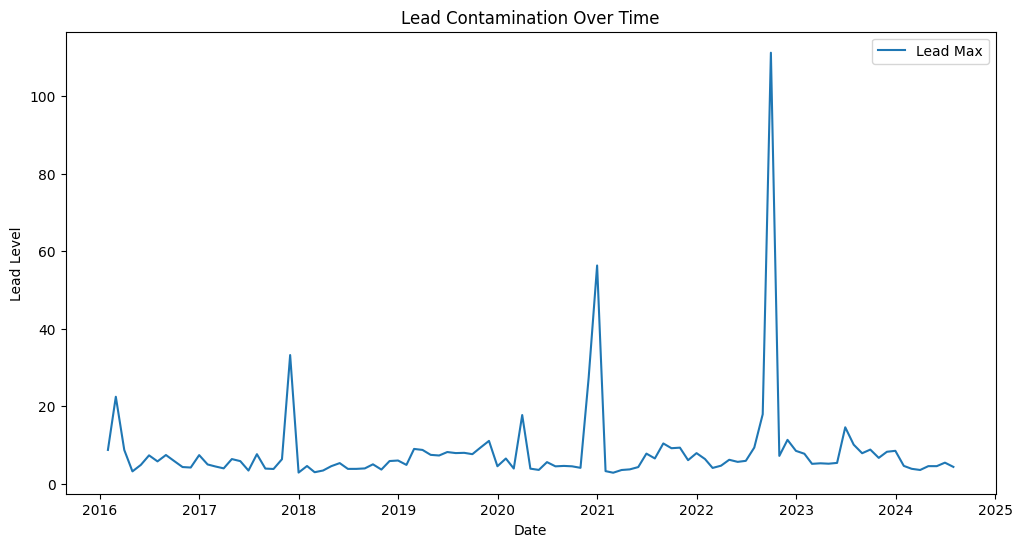

In [28]:
# I'm visualizing the average monthly max lead levels over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['lead_max'], label='Lead Max')  #  plotting the monthly average of the maximum lead levels over time.
plt.title('Lead Contamination Over Time')
plt.xlabel('Date')
plt.ylabel('Lead Level')
plt.legend()
plt.show()


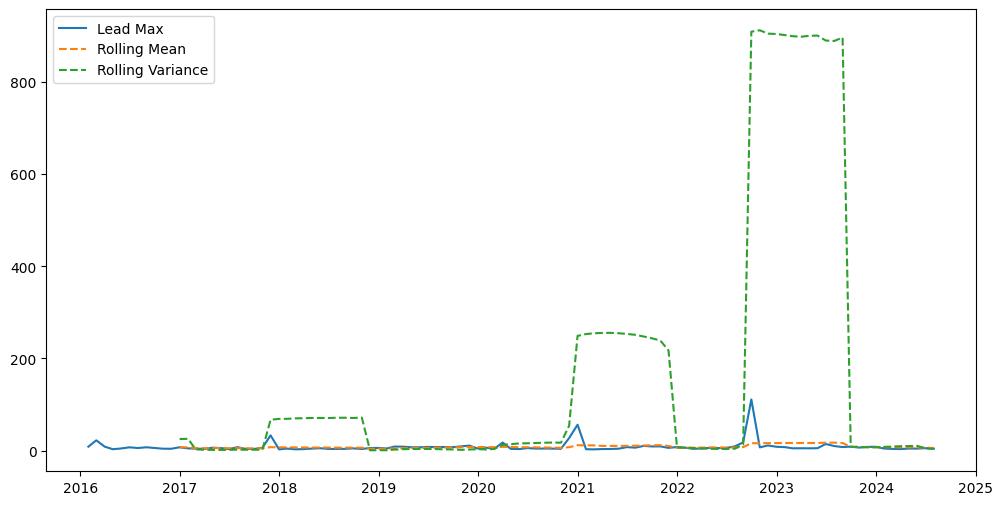

In [29]:
# Plot rolling mean and variance
# Drop rows with missing values
df_monthly = df_monthly.dropna(subset=['lead_max'])

rolling_mean = df_monthly['lead_max'].rolling(window=12).mean()
rolling_variance = df_monthly['lead_max'].rolling(window=12).var()

plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['lead_max'], label='Lead Max')
plt.plot(df_monthly.index, rolling_mean, label='Rolling Mean', linestyle='--')
plt.plot(df_monthly.index, rolling_variance, label='Rolling Variance', linestyle='--')
plt.legend()
plt.show()

# Rolling Mean not changing much → no trend

# Rolling Variance changes → volatility in some years (especially near spikes)

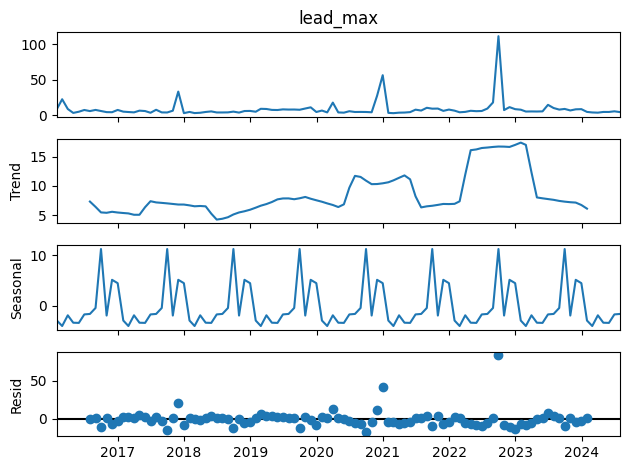

In [30]:
# Seasonal decomposition using statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_monthly['lead_max'], model='additive', period=12)
result.plot()
plt.show()

# Observed: Original data
# Trend: Underlying slow-moving average
# Seasonal: Repeating annual pattern
# Residual: Random noise/spikes

In [31]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_monthly['lead_max'].dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# p-value < 0.05 → reject null hypothesis → the data is stationary
# That means: No trend. Seasonality is there, but the structure isn’t drifting.

ADF Statistic: -8.808967988948229
p-value: 2.015502076311383e-14


<Figure size 1200x600 with 0 Axes>

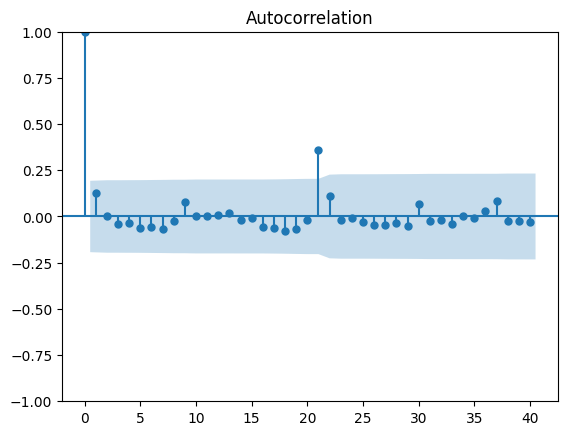

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(df_monthly['lead_max'], lags=40)
plt.show()

# ACF: Bars at lags 12, 24, etc. → yearly seasonality

<Figure size 1200x600 with 0 Axes>

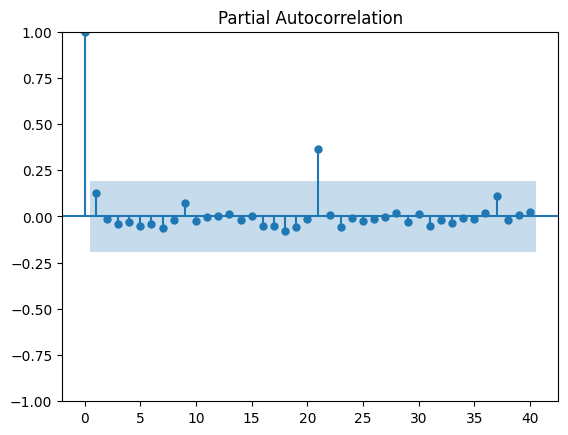

In [33]:
plt.figure(figsize=(12, 6))
plot_pacf(df_monthly['lead_max'], lags=40)
plt.show()
# PACF: Helps decide AR terms (lags) to use in the model

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMA model
model = SARIMAX(df_monthly['lead_max'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  #AR(1), differencing(1), MA(1),  Seasonal ARIMA with 12-month periodicity
result = model.fit()

# Model summary
print(result.summary())

# AIC = 745.3: Lower is better
# Many p-values > 0.05 → some terms might not be significant
# Convergence Warning = model might not be optimal, maybe noisy data


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                           lead_max   No. Observations:                  103
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -367.653
Date:                            Thu, 17 Apr 2025   AIC                            745.306
Time:                                    04:02:08   BIC                            757.805
Sample:                                01-31-2016   HQIC                           750.346
                                     - 07-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1396      0.183      0.764      0.445      -0.218       0.498
ma.L1         -0.9995     12.115   

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
# Try different configurations and compare AIC/BIC
model_2 = SARIMAX(df_monthly['lead_max'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
result_2 = model_2.fit()
print(f"AIC for Model 2: {result_2.aic}")

# Compare AIC values and pick the best model
#  First model is still better, despite warnings.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


AIC for Model 2: 748.8747896002584


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
import itertools
import warnings
warnings.filterwarnings("ignore")

p = q = range(0, 3)
d = [1]  # You already know differencing is needed
seasonal_pdq = [(x[0], x[1], x[2], 12)
                for x in itertools.product([0,1], [1], [0,1,2])]


lowest_aic = float('inf')
best_params = None

for param in itertools.product(p, d, q):
    for seasonal_param in seasonal_pdq:
        try:
            mod = SARIMAX(df_monthly['lead_max'],
                          order=param,
                          seasonal_order=seasonal_param,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_params = (param, seasonal_param)
        except:
            continue

print(f"Best SARIMA: {best_params} with AIC {lowest_aic}")

Best SARIMA: ((0, 1, 1), (0, 1, 2, 12)) with AIC 158.79891598310056


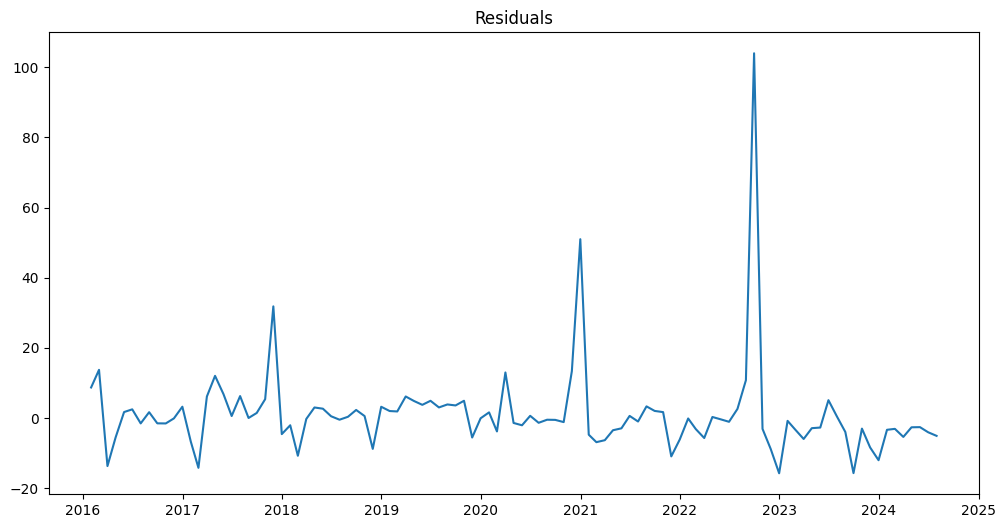

In [ ]:
# Plot residuals
model = SARIMAX(df_monthly['lead_max'], order=(0, 1, 1), seasonal_order=(0, 1, 2, 12))  #AR(1), differencing(1), MA(1),  Seasonal ARIMA with 12-month periodicity
result = model.fit()

residuals = result.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()


# If residuals look like random noise (no patterns), model is good.
# If residuals have structure → model missed something
# Big spikes = model couldn’t capture those (like end-2022)

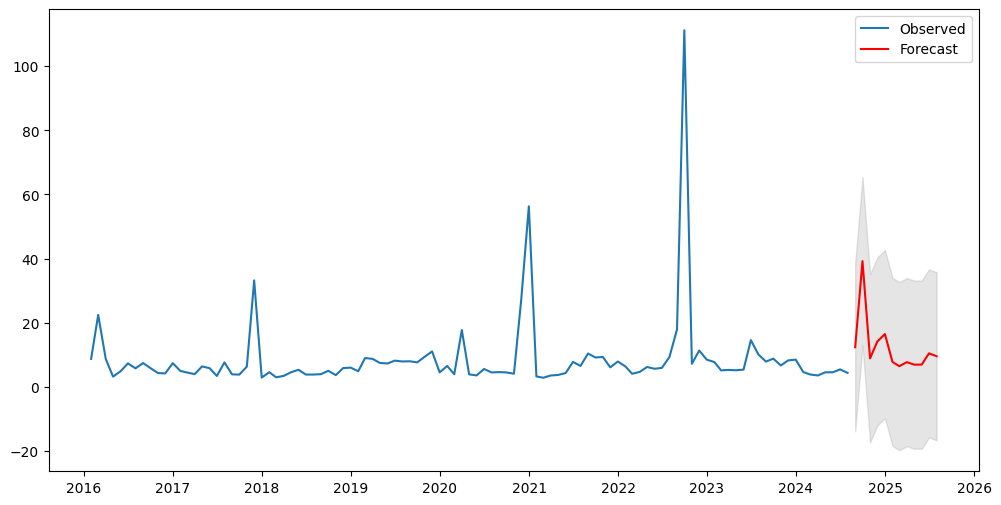

In [ ]:

# Plot forecast
forecast = result.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['lead_max'], label='Observed')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)
plt.legend()
plt.show()